In [ ]:
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Installing dependencies from requirements.txt...")
    !pip install -r https://raw.githubusercontent.com/garyuppal/blog-code/refs/heads/main/double_descent_overview/requirements.txt
else:
    print("Running locally...")

running locally


In [1]:
import numpy as np
import matplotlib.pyplot as plt

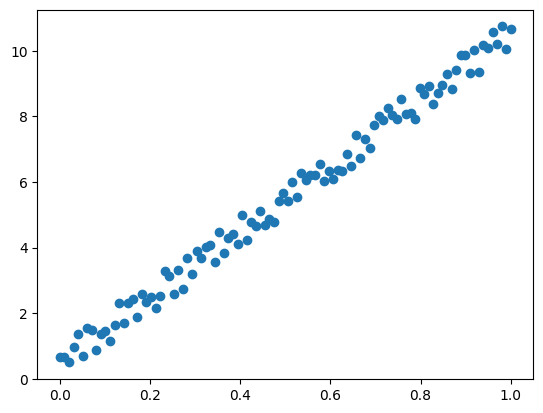

In [3]:
x = np.linspace(0,1,100)
y = 10*x + np.random.rand(len(x),)

fig, ax = plt.subplots()
ax.scatter(x,y)